# PIR - Data Exploration and Missing Values
<span style="color:red">This notebook is used for data exploration and provides a detailed implementation of the required transformations and preprocessing steps. This includes removing the COVID period as well as identifying stations with the fewest data points.<span>

## 1: Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# Load the Data
x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')
x_test = pd.read_csv('x_test.csv')
y_test_example = pd.read_csv('y_test_exemple.csv')
y_test_LSTM_v1 = pd.read_csv('y_test_LSTM_v1.csv')

## 2: Dataset Processing

In [2]:
# Create the 'index' variable in x_train
x_train['index'] = x_train['date'].str.cat(x_train['station'], sep='_')
x_train.head()

,date,station,job,ferie,vacances,index
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3


In [3]:
# Merge x_train and y_train on 'index'
data = pd.merge(x_train, y_train, on='index')
data = data[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']] #reorder columns
data.head()

,date,station,index,job,ferie,vacances,y
0,2015-01-01,1J7,2015-01-01_1J7,1,1,1,7
1,2015-01-01,O2O,2015-01-01_O2O,1,1,1,0
2,2015-01-01,8QR,2015-01-01_8QR,1,1,1,9
3,2015-01-01,UMC,2015-01-01_UMC,1,1,1,9
4,2015-01-01,FK3,2015-01-01_FK3,1,1,1,28


<span style="color:red">The next code prepares the dataset for analysis in a structured and machine-readable way.</span>


In [4]:
# Convert the date to pandas datetime format
data['date'] = pd.to_datetime(data['date'])

# Create a mapping dictionary to replace station names with numeric IDs
X_station = data['station']
station_mapping = {station: i for i, station in enumerate(X_station.unique())}
data['station_id'] = data['station'].map(station_mapping)

# Organize data by station and date
stations = data['station'].unique()
    # Create a dictionnary sorted by date where:
    # - the key is the station name
    # - the value is a Dataframe containing only data for that station
df_per_station = {station: data[data['station'] == station].sort_values(by='date') for station in stations}

In [5]:
# Total number of stations
print(f'Total number of stations: {len(df_per_station)}')

Total number of stations: 439


## 3: Average Attendance

In [6]:
# Average attendance per date
daily_average_attendance = data.groupby('date')['y'].mean().reset_index()

# Rename the column for clarity
daily_average_attendance.rename(columns={'y': 'y_average'}, inplace=True)

daily_average_attendance.head()

,date,y_average
0,2015-01-01,646.255319
1,2015-01-02,2297.683099
2,2015-01-03,1673.245902
3,2015-01-04,1244.572770
4,2015-01-05,4440.103044


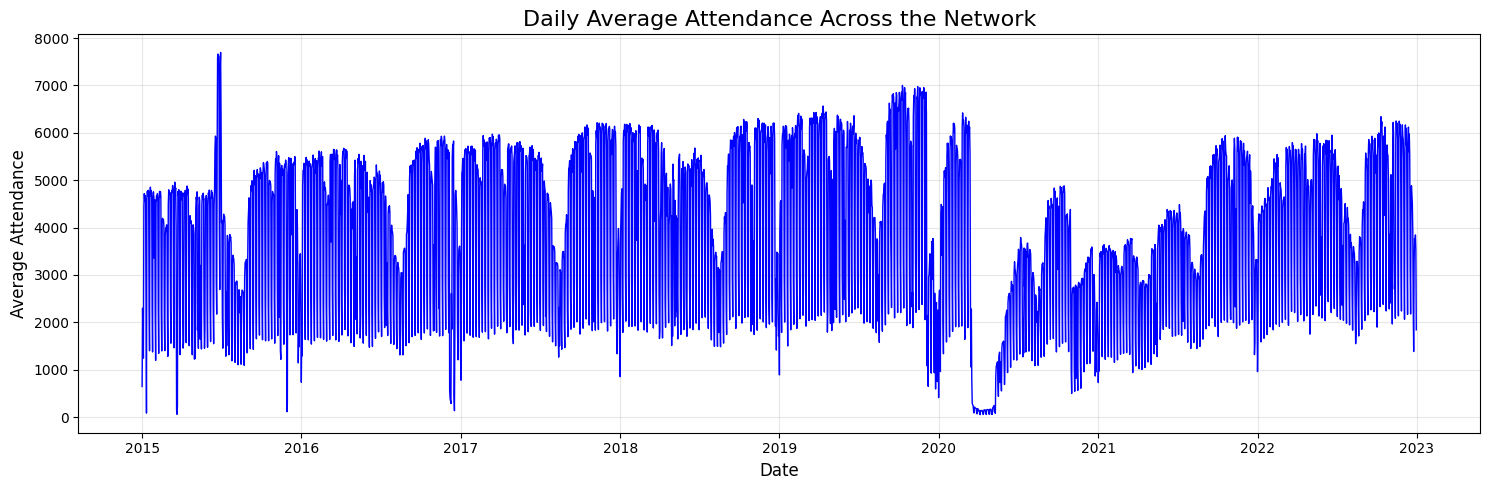

In [7]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(daily_average_attendance['date'], daily_average_attendance['y_average'], color='blue', linewidth=1)
plt.title('Daily Average Attendance Across the Network', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Attendance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4 Remove Covid period

<span style="color:blue">The period affected by COVID-19 lockdowns is removed from the dataset because during this months, public transport usage was heavily disrupted and does not reflect normal passenger behaviour. Including this data could bias our predictive model, as it would learn patterns that are not representative of typical demand.</span>

Quarantine periods: 2020-03-17 to 2020-05-11,
2020-10-30 to 2020-12-15,
2021-04-03 to 2021-05-03.

-> remove data from March 2020 to June 2021


In [8]:
# Identification of the Covid period
df_xtg = df_per_station['XTG']
df_xtg = df_xtg.set_index('date').sort_index()

# Start
target_start_date = pd.to_datetime('2020-03-01')
x_start = df_xtg.index.get_indexer([target_start_date], method='nearest')[0]
print("start:", x_start)


# End
target_end_date = pd.to_datetime('2021-05-31')
x_end = df_xtg.index.get_indexer([target_end_date], method='nearest')[0]
print("end:", x_end)

start: 1884
end: 2340


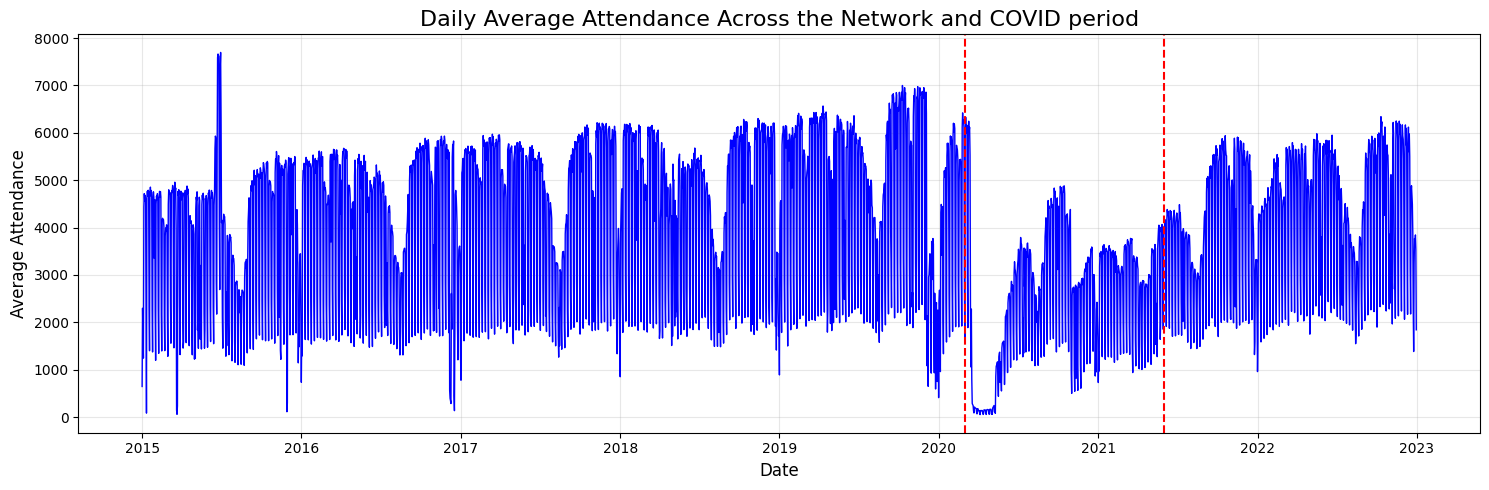

In [9]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(daily_average_attendance['date'], daily_average_attendance['y_average'], color='blue', linewidth=1)
plt.axvline(x=target_start_date, color='red', linestyle='--')
plt.axvline(x=target_end_date, color='red', linestyle='--')
plt.title('Daily Average Attendance Across the Network and COVID period', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Attendance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<span style="color:red">The impact of the COVID-19 period is clearly visible in the graph of average attendance.</span>

In [10]:
# Stations names
df_per_station.keys()

dict_keys(['1J7', 'O2O', '8QR', 'UMC', 'FK3', 'I1K', 'KY6', 'V8D', 'EK4', '357', 'O7B', 'RYX', 'TEP', 'CUF', '4UY', 'I9K', 'FA8', 'EPD', 'VML', 'GV0', 'MNO', '5KB', '6WR', 'BRZ', 'BUY', 'C3A', '276', 'IFB', '1PW', '6UW', 'RR1', 'XTG', 'JXV', 'OD3', 'YTV', 'Z2T', 'GOJ', '8X9', 'R83', 'XIG', 'CSD', '30R', 'OOY', 'JCN', 'G10', 'MM6', 'NT4', 'IOR', 'J9C', 'VI4', '8WZ', 'FYB', '5GK', 'QQJ', 'E9M', 'F77', 'JX6', 'HW6', '30I', 'CWQ', '4IM', '59A', 'BZ0', '5S5', 'MK9', 'JCW', '34L', 'EBP', 'V4D', '3KU', 'BNR', 'VGQ', 'B3W', 'HOX', '9WY', 'N7J', '4YU', 'JD3', 'FBH', 'P4J', 'QV8', 'SH9', 'DBV', '3NQ', '651', 'HOC', '3W6', 'EIZ', '87K', '289', 'XRB', 'BKJ', 'T91', 'NVE', 'CJP', '5U5', 'BPW', 'GKH', 'XOK', '72S', '4PO', '5PK', '5WG', 'J9O', '6DU', 'MIH', 'DSX', 'F7I', 'OYD', 'P3G', 'B3D', 'B61', '8E0', '7NG', '222', '1TE', 'CYD', 'GN3', '11W', '4SH', '3NS', 'OTS', '25G', 'XUL', 'Z5T', '56P', 'WIX', 'TPX', 'F30', 'OUG', 'APN', 'WRR', 'K5Q', 'D68', '2P1', 'B65', 'EFN', 'ROF', '1EJ', 'H1M', 'B9M', '1

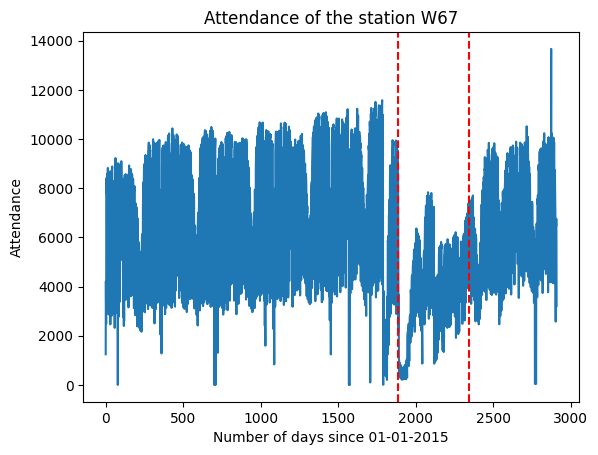

In [11]:
# Plot the evolution through time for one station
def plot_one_station_attendance(station_name, covid_period=False):
    plt.plot(np.array(df_per_station[station_name]['y']))
    if covid_period:
        plt.axvline(x=x_start, color='red', linestyle='--')
        plt.axvline(x=x_end, color='red', linestyle='--')
    plt.title(f'Attendance of the station {station_name}')
    plt.xlabel('Number of days since 01-01-2015')
    plt.ylabel('Attendance')
    plt.show()

# One example
station_name = 'W67'
plot_one_station_attendance(station_name, covid_period=True)

# Other examples
#plot_one_station_attendance('Q62', covid_period=True)
#plot_one_station_attendance('NZP', covid_period=True)
#plot_one_station_attendance('CM6', covid_period=True)
#plot_one_station_attendance('TEP', covid_period=True)
#plot_one_station_attendance('I9K', covid_period=True)


In [12]:
# Filtering
# target_start_date = 2020-03-01
# target_end_date = 2021-05-31
mask = (data['date'] < target_start_date) | (data['date'] > target_end_date)
data = data[mask].reset_index(drop=True)

In [13]:
# Update de dictionnary

# Recreate the mapping dictionary to replace station names with numeric IDs
X_station = data['station']
station_mapping = {station: i for i, station in enumerate(X_station.unique())}
data['station_id'] = data['station'].map(station_mapping)

# Organize data by station and date
stations = data['station'].unique()

# Recreate the dictionnary sorted by date
df_per_station = {station: data[data['station'] == station].sort_values(by='date') for station in stations}

Text(0, 0.5, 'Attendance')

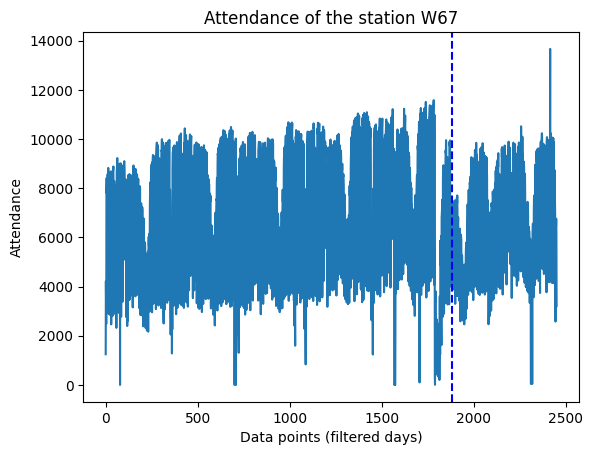

In [14]:
# Replot the evolution through time after filtering
plt.plot(np.array(df_per_station[station_name]['y']))
plt.title(f'Attendance of the station {station_name}')
plt.axvline(x=x_start, color='blue', linestyle='--') # shows where the filter have been applied
plt.xlabel('Data points (filtered days)')
plt.ylabel('Attendance')

## 4: Creation of y_test

In [15]:
# Overview of y_test_example provided by the platform
print(y_test_example.head())

            index      y
0  2023-01-01_1J7  10000
1  2023-01-01_O2O  10000
2  2023-01-01_8QR  10000
3  2023-01-01_L58  10000
4  2023-01-01_UMC  10000


In [16]:
# Creation of y_test
def create_y_test(x_test):
    y_test = pd.DataFrame()
    y_test['index'] = x_test['index']
    y_test['y'] = 0
    return y_test

y_test = create_y_test(x_test)
print(y_test.head())

            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


In [17]:
# Merge x_test and y_test into "data_test"
data_test = pd.merge(x_test, y_test, on='index')
data_test = data_test[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']] # reorder columns
data_test.head()

,date,station,index,job,ferie,vacances,y
0,2023-01-01,1J7,2023-01-01_1J7,0,1,1,0
1,2023-01-01,O2O,2023-01-01_O2O,0,1,1,0
2,2023-01-01,8QR,2023-01-01_8QR,0,1,1,0
3,2023-01-01,L58,2023-01-01_L58,0,1,1,0
4,2023-01-01,UMC,2023-01-01_UMC,0,1,1,0


In [18]:
# Convert the date to pandas datetime format
data_test['date'] = pd.to_datetime(data_test['date'])
# Create a mapping dictionary to replace station names with numeric IDs
X_station_test = data_test['station']
station_mapping_test = {station: i for i, station in enumerate(X_station_test.unique())}
data_test['station_id'] = data_test['station'].map(station_mapping_test)

# Organize data by station and date
stations_test = data_test['station'].unique()
# Create a dictionnary sorted by date where:
# - the key is the station name
# - the value is a Dataframe containing only data for that station
df_per_station_test = {station: data_test[data_test['station'] == station].sort_values(by='date') for station in stations_test}


## 5: Checking for the presence of missing values

### 5.1 Training Data

In [19]:
# Training Data
idx = 1
min_points = float('inf')
max_points = float('-inf')
station_min = None
station_max = None

for name_station, df_train in df_per_station.items():
    n_station = len(df_per_station)
    n_points = len(df_train)
    print(f"Station {idx}/{n_station} {name_station}: {n_points} points")
    
    # Min
    if n_points < min_points:
        min_points = n_points
        station_min = name_station
    
    # Max
    if n_points > max_points:
        max_points = n_points
        station_max = name_station
    
    idx += 1

print("\nStation with the most data points:", station_max, "->", max_points)
print("Station with the fewest data points:", station_min, "->", min_points)

Station 1/439 1J7: 2355 points
Station 2/439 O2O: 2390 points
Station 3/439 8QR: 2407 points
Station 4/439 UMC: 2426 points
Station 5/439 FK3: 2438 points
Station 6/439 I1K: 2425 points
Station 7/439 KY6: 2465 points
Station 8/439 V8D: 2426 points
Station 9/439 EK4: 2444 points
Station 10/439 357: 2420 points
Station 11/439 O7B: 2429 points
Station 12/439 RYX: 2435 points
Station 13/439 TEP: 2445 points
Station 14/439 CUF: 2433 points
Station 15/439 4UY: 2444 points
Station 16/439 I9K: 2445 points
Station 17/439 FA8: 2438 points
Station 18/439 EPD: 2437 points
Station 19/439 VML: 2299 points
Station 20/439 GV0: 2433 points
Station 21/439 MNO: 2367 points
Station 22/439 5KB: 2436 points
Station 23/439 6WR: 2435 points
Station 24/439 BRZ: 2448 points
Station 25/439 BUY: 2433 points
Station 26/439 C3A: 2441 points
Station 27/439 276: 2426 points
Station 28/439 IFB: 2435 points
Station 29/439 1PW: 2465 points
Station 30/439 6UW: 2451 points
Station 31/439 RR1: 2454 points
Station 32/439 XT

<span style="color:red">We observe that some stations have far fewer data points than others, meaning they lack attendance values for several days. This could be due to stations being opened later, undergoing construction, or other temporary issues.</span>

In [20]:
# Thresold
thresold_points = 2000

# List of station with few data points
short_stations_df = pd.DataFrame([
    {
        'station': name_station,
        'n_points': len(df),
        'first_date': df['date'].min(),
        'last_date': df['date'].max()
    }
    for name_station, df in df_per_station.items()
    if len(df) < thresold_points
])

# Show the list
print(short_stations_df)

   station  n_points first_date  last_date
0      TPX      1734 2015-01-01 2022-12-31
1      EFN      1743 2015-01-01 2022-12-31
2      B9M      1682 2015-01-01 2022-12-31
3      52H      1502 2015-01-01 2022-12-31
4      92P      1706 2015-01-01 2022-12-31
5      L58      1861 2015-01-02 2022-12-31
6      OWM      1514 2017-01-17 2022-12-31
7      48S      1548 2017-07-02 2022-12-31
8      V2P      1547 2017-06-06 2022-12-31
9      N9K      1545 2017-07-01 2022-12-31
10     EQX      1513 2015-01-03 2022-12-30
11     P6E       181 2022-07-01 2022-12-31
12     BDC       181 2022-07-01 2022-12-31
13     W80       169 2022-07-15 2022-12-31
14     W14       182 2022-07-02 2022-12-31
15     QD6        70 2022-08-02 2022-10-10


In [21]:
def plot_stations_subplots(stations_list, n_cols=1):
    n_stations = len(stations_list)
    n_rows = (n_stations + n_cols - 1) // n_cols  # calculate the number of rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharex=False)
    axes = axes.flatten()  # flattend to iterate easily
    
    covid_start = pd.to_datetime("2020-03-01")
    covid_end = pd.to_datetime("2021-05-31")
    
    for ax, name_station in zip(axes, stations_list):
        df = df_per_station[name_station].copy()
        df['date'] = pd.to_datetime(df['date'])
        first_date = df['date'].min().date()
        
        # Plot the attendance
        ax.plot(df['date'], df['y'], marker='o', markersize=3, linestyle='-')
        
        # COVID period in gray
        ax.axvspan(covid_start, covid_end, color='gray', alpha=0.5)
        
        # Detect missing dates, in red
        full_dates = pd.date_range(df['date'].min(), df['date'].max())
        missing_dates = full_dates.difference(df['date'])
        for missing_date in missing_dates:
            ax.axvspan(missing_date, missing_date + pd.Timedelta(days=1), color='red', alpha=0.1)
        
        # Titles
        ax.set_title(f"Station {name_station} ({len(df)} points / first date {first_date})")
        ax.set_xlabel('Date')
        ax.set_ylabel('Attendance')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
        
        # Legend
        covid_patch = mpatches.Patch(color='gray', alpha=0.5, label='COVID period excluded')
        missing_patch = mpatches.Patch(color='red', alpha=0.1, label='Missing data')
        ax.legend(handles=[covid_patch, missing_patch])
    
    # Hide empty axes if there are fewer subplots than axes
    for j in range(len(stations_list), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


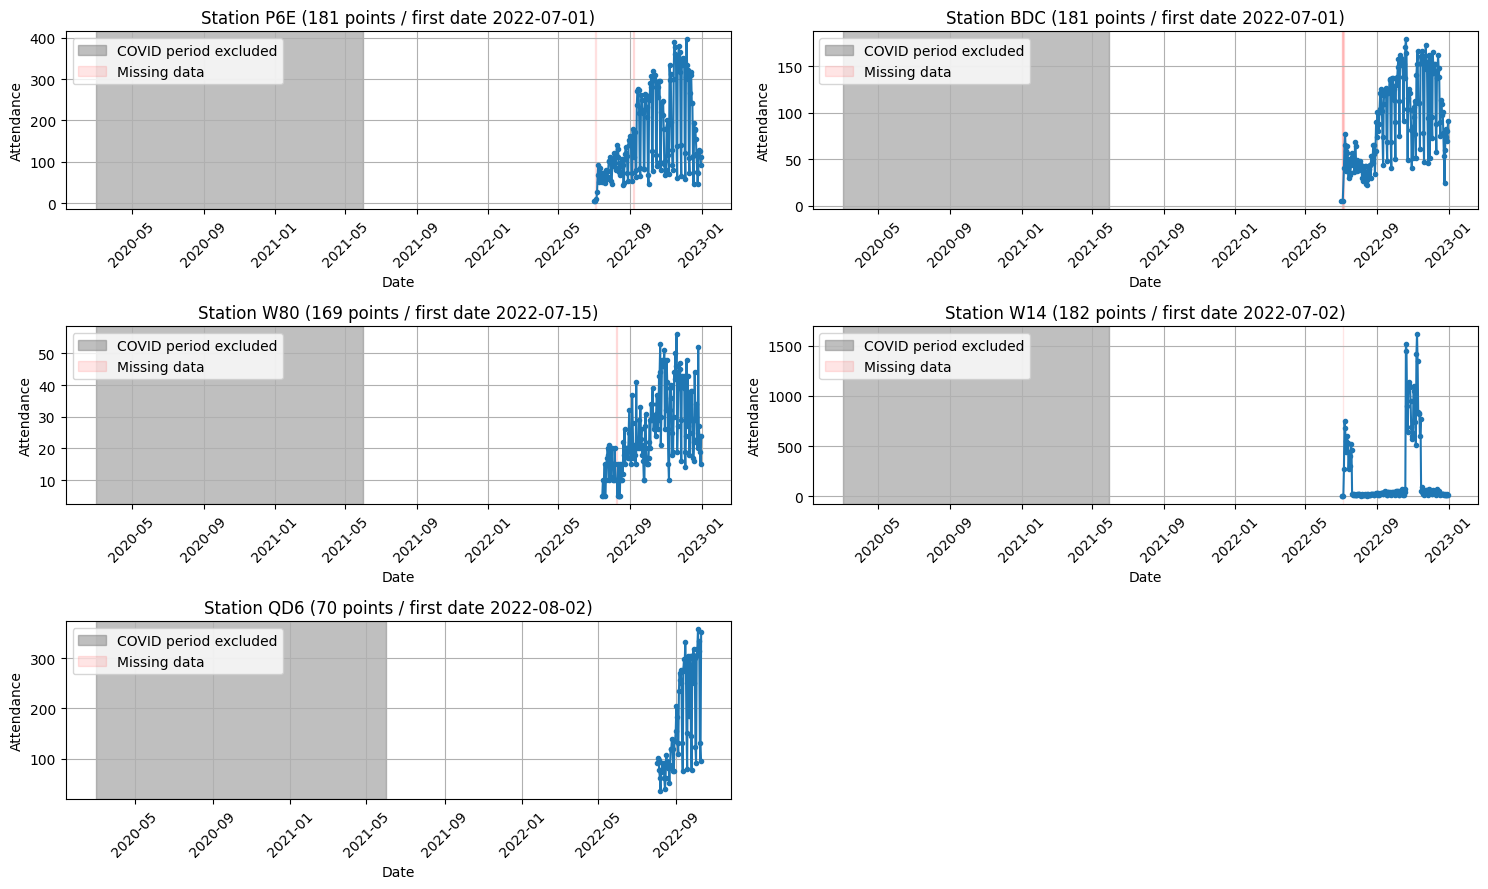

In [22]:
# Iteration over the most recent stations
recent_stations = short_stations_df[-5:]
plot_stations_subplots(recent_stations['station'].tolist(), n_cols=2)

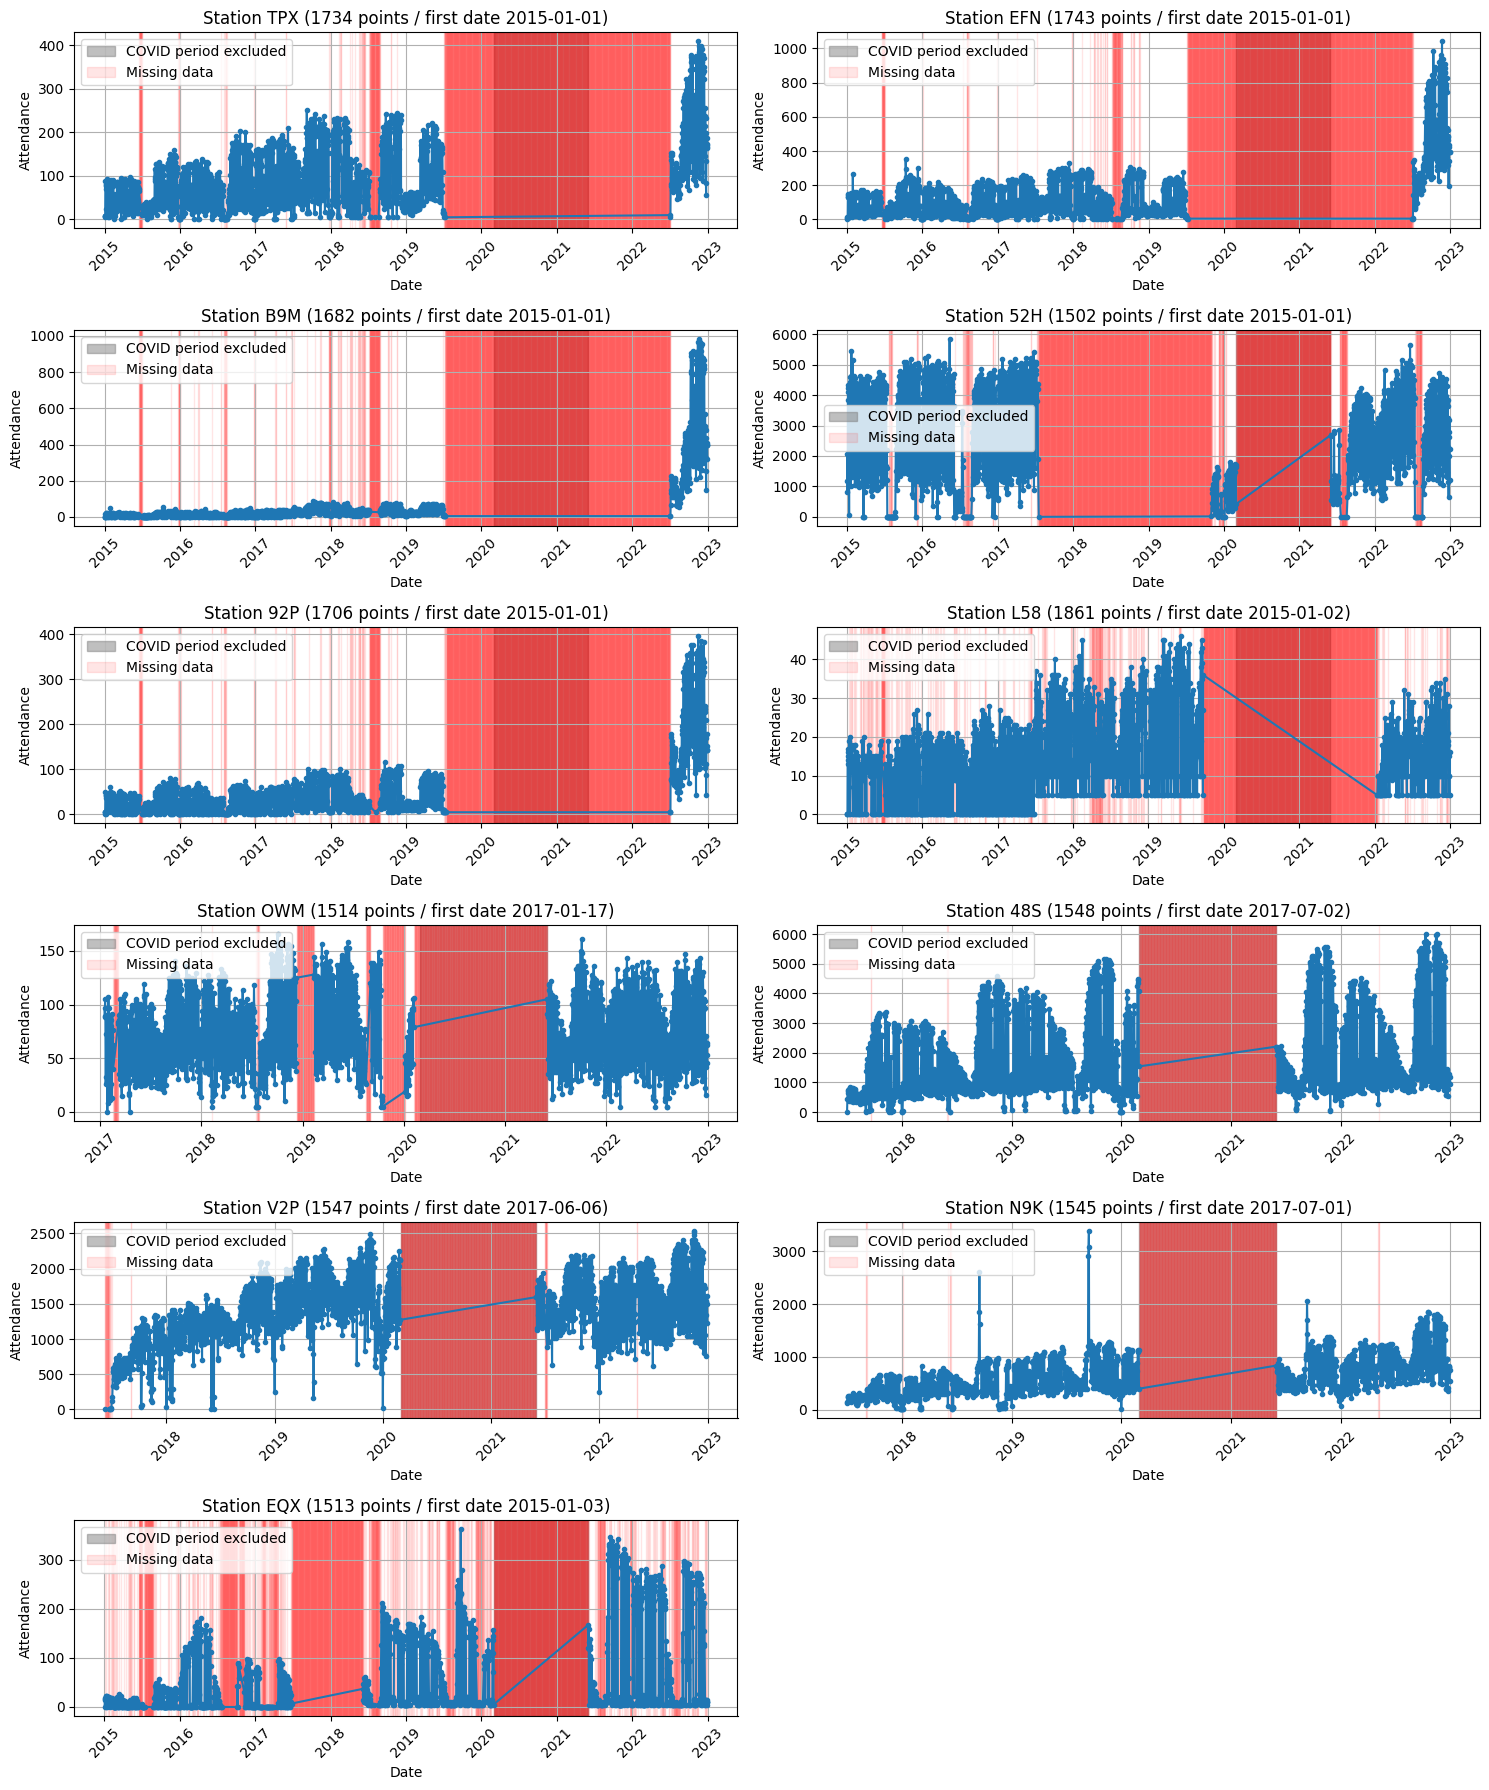

In [23]:
# Iteration over the other stations with few points
other_short_stations = short_stations_df[:-5]
plot_stations_subplots(other_short_stations['station'].tolist(), n_cols=2)

### 5.2 Test Data

In [24]:
# Number of data points in y_test_example
print(len(y_test_example))

# Number of data points in x_test
print(len(x_test))

# Checking that all indices match
print(x_test.index.equals(y_test_example.index))

78652
78652
True


<span style="color:red">The y_test_example file provided as a submission example follows exactly the same indices as the x_test file. Therefore, if a station is missing on a given day, no prediction is expected for that station on that day.</span>

In [25]:
# Number of points in y_test_LSTM_v1
print(len(y_test_LSTM_v1))

78652


In [32]:
print(df_per_station.keys())

dict_keys(['1J7', 'O2O', '8QR', 'UMC', 'FK3', 'I1K', 'KY6', 'V8D', 'EK4', '357', 'O7B', 'RYX', 'TEP', 'CUF', '4UY', 'I9K', 'FA8', 'EPD', 'VML', 'GV0', 'MNO', '5KB', '6WR', 'BRZ', 'BUY', 'C3A', '276', 'IFB', '1PW', '6UW', 'RR1', 'XTG', 'JXV', 'OD3', 'YTV', 'Z2T', 'GOJ', '8X9', 'R83', 'XIG', 'CSD', '30R', 'OOY', 'JCN', 'G10', 'MM6', 'NT4', 'IOR', 'J9C', 'VI4', '8WZ', 'FYB', '5GK', 'QQJ', 'E9M', 'F77', 'JX6', 'HW6', '30I', 'CWQ', '4IM', '59A', 'BZ0', '5S5', 'MK9', 'JCW', '34L', 'EBP', 'V4D', '3KU', 'BNR', 'VGQ', 'B3W', 'HOX', '9WY', 'N7J', '4YU', 'JD3', 'FBH', 'P4J', 'QV8', 'SH9', 'DBV', '3NQ', '651', 'HOC', '3W6', 'EIZ', '87K', '289', 'XRB', 'BKJ', 'T91', 'NVE', 'CJP', '5U5', 'BPW', 'GKH', 'XOK', '72S', '4PO', '5PK', '5WG', 'J9O', '6DU', 'MIH', 'DSX', 'F7I', 'OYD', 'P3G', 'B3D', 'B61', '8E0', '7NG', '222', '1TE', 'CYD', 'GN3', '11W', '4SH', '3NS', 'OTS', '25G', 'XUL', 'Z5T', '56P', 'WIX', 'TPX', 'F30', 'OUG', 'APN', 'WRR', 'K5Q', 'D68', '2P1', 'B65', 'EFN', 'ROF', '1EJ', 'H1M', 'B9M', '1

In [26]:
# Test Data
idx = 1
min_points = float('inf')
max_points = float('-inf')
station_min = None
station_max = None

for name_station, df_train in df_per_station_test.items():
    n_station = len(df_per_station)
    n_points = len(df_train)
    print(f"Station {idx}/{n_station} {name_station}: {n_points} points")
    
    # Min
    if n_points < min_points:
        min_points = n_points
        station_min = name_station
    
    # Max
    if n_points > max_points:
        max_points = n_points
        station_max = name_station
    
    idx += 1

print("\nStation with the most data points:", station_max, "->", max_points)
print("Station with the fewest data points:", station_min, "->", min_points)

Station 1/439 1J7: 175 points
Station 2/439 O2O: 173 points
Station 3/439 8QR: 175 points
Station 4/439 L58: 144 points
Station 5/439 UMC: 180 points
Station 6/439 FK3: 181 points
Station 7/439 I1K: 180 points
Station 8/439 KY6: 181 points
Station 9/439 V8D: 181 points
Station 10/439 EK4: 181 points
Station 11/439 357: 179 points
Station 12/439 O7B: 181 points
Station 13/439 RYX: 179 points
Station 14/439 TEP: 181 points
Station 15/439 CUF: 178 points
Station 16/439 4UY: 165 points
Station 17/439 I9K: 181 points
Station 18/439 FA8: 181 points
Station 19/439 EPD: 181 points
Station 20/439 VML: 167 points
Station 21/439 GV0: 181 points
Station 22/439 5KB: 181 points
Station 23/439 6WR: 181 points
Station 24/439 BRZ: 181 points
Station 25/439 BUY: 181 points
Station 26/439 C3A: 181 points
Station 27/439 276: 180 points
Station 28/439 IFB: 180 points
Station 29/439 1PW: 181 points
Station 30/439 6UW: 181 points
Station 31/439 RR1: 178 points
Station 32/439 XTG: 179 points
Station 33/439 JX

In [27]:
# Thresold
thresold_points = 160

# List of station with few data points
short_test_station_df = pd.DataFrame([
    {
        'station': name_station,
        'n_points': len(df),
        'first_date': df['date'].min(),
        'last_date': df['date'].max()
    }
    for name_station, df in df_per_station_test.items()
    if len(df) < thresold_points
])

# Show the list
print(short_test_station_df)

  station  n_points first_date  last_date
0     L58       144 2023-01-01 2023-06-30
1     J9C       123 2023-01-01 2023-06-30
2     B8A       158 2023-01-01 2023-06-30
3     VV4       158 2023-01-01 2023-06-30
4     EQX       154 2023-01-02 2023-06-30
5     QD6        48 2023-04-26 2023-06-12


In [28]:
print(short_stations_df)

   station  n_points first_date  last_date
0      TPX      1734 2015-01-01 2022-12-31
1      EFN      1743 2015-01-01 2022-12-31
2      B9M      1682 2015-01-01 2022-12-31
3      52H      1502 2015-01-01 2022-12-31
4      92P      1706 2015-01-01 2022-12-31
5      L58      1861 2015-01-02 2022-12-31
6      OWM      1514 2017-01-17 2022-12-31
7      48S      1548 2017-07-02 2022-12-31
8      V2P      1547 2017-06-06 2022-12-31
9      N9K      1545 2017-07-01 2022-12-31
10     EQX      1513 2015-01-03 2022-12-30
11     P6E       181 2022-07-01 2022-12-31
12     BDC       181 2022-07-01 2022-12-31
13     W80       169 2022-07-15 2022-12-31
14     W14       182 2022-07-02 2022-12-31
15     QD6        70 2022-08-02 2022-10-10


In [29]:
def plot_stations_subplots(stations_list, n_cols=2):
    n_stations = len(stations_list)
    n_rows = (n_stations + n_cols - 1) // n_cols 
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), sharex=False)
    axes = axes.flatten() 
    
    for ax, name_station in zip(axes, stations_list):
        df = df_per_station_test[name_station].copy()
        df['date'] = pd.to_datetime(df['date'])
        first_date = df['date'].min().date()
        
        # Plot the attendance
        ax.plot(df['date'], df['y'], marker='o', markersize=3, linestyle='-')
        
        # Detect missing values
        full_dates = pd.date_range(df['date'].min(), df['date'].max())
        missing_dates = full_dates.difference(df['date'])
        for missing_date in missing_dates:
            ax.axvspan(missing_date, missing_date + pd.Timedelta(days=1), color='red', alpha=0.1)
        
        # Titles
        ax.set_title(f"Station {name_station} ({len(df)} points / first date {first_date})")
        ax.set_xlabel('Date')
        ax.set_ylabel('Attendance')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
        
        # Legend
        missing_patch = mpatches.Patch(color='red', alpha=0.1, label='Missing data')
        ax.legend(handles=[missing_patch])
    
    # Hide empty axes if there are fewer subplots than axes
    for j in range(len(stations_list), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

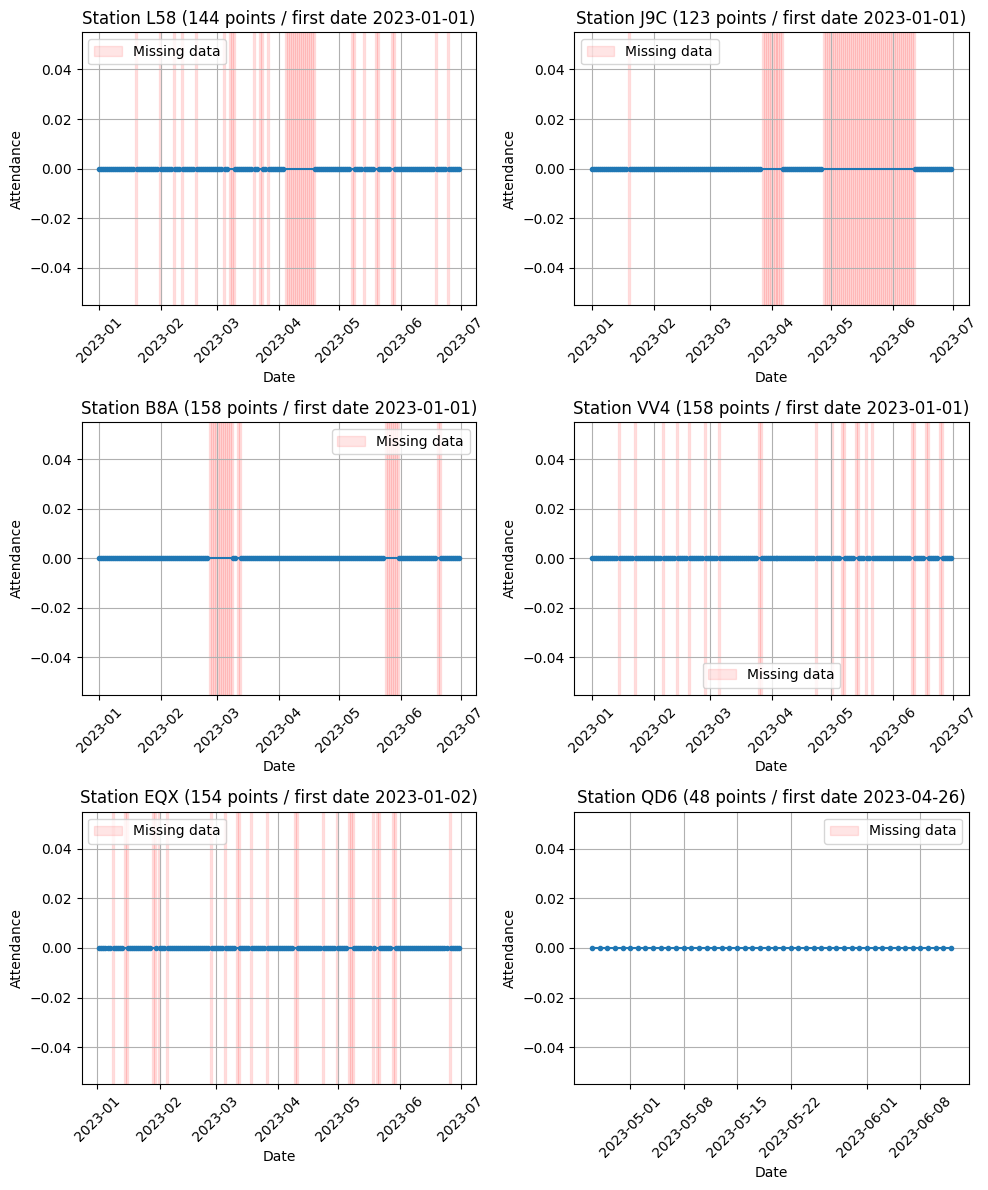

In [30]:
# Iteration over the stations with few data points in x_test
plot_stations_subplots(short_test_station_df['station'].tolist(), n_cols=2)